In [1]:
import neural_net_without_autograd as NNC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import  train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
np.random.seed(2)

# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise
z = z.reshape((len(z), 1))      # have to reshape the data to get the correct output

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

In [7]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NNC.NeuralNet(network_input_size, 
                            layer_output_sizes, 
                            activations, 
                            loss_fn='mse', 
                            epsilon=0.1, 
                            batch_size=100, 
                            epochs=1000, 
                            llambda=0.0001))
])

# getting data for confusion matrix
pipeline.fit(X_train, z_train)

pipeline.score(X_test, z_test)

Epoch 0: MSE = 0.05055889818822568
Epoch 100: MSE = 0.0023371036573229436
Epoch 200: MSE = 0.00177837581070343
Epoch 300: MSE = 0.0016118368500902419
Epoch 400: MSE = 0.0015088463089345052
Epoch 500: MSE = 0.0014392700863148223
Epoch 600: MSE = 0.0013825154551473555
Epoch 700: MSE = 0.0013540412244841932
Epoch 800: MSE = 0.0013130942909128419
Epoch 900: MSE = 0.00129180482230201


0.0012567031769879122

### Gridsearch

In [5]:
k_folds = KFold(n_splits=10)

pipeline = Pipeline([
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=100, epochs=500))
])
param_grid = {
    'model__epsilon': np.logspace(-4, -1, 4)#,
    #'model__llambda': np.logspace(-4, -1, 4)
}

grid_search = GridSearchCV(estimator=pipeline,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=k_folds,
                verbose=1,
                n_jobs=1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Epoch 0: MSE = 2.7225506725893873
Epoch 100: MSE = 0.1378089868244319
Epoch 200: MSE = 0.07613846228681755
Epoch 300: MSE = 0.05005584773302323
Epoch 400: MSE = 0.03868189193399425
Epoch 0: MSE = 2.3509657095280554
Epoch 100: MSE = 0.5054790251729827
Epoch 200: MSE = 0.226979677159757
Epoch 300: MSE = 0.11292861273224485
Epoch 400: MSE = 0.06507838181317613
Epoch 0: MSE = 0.27870342049684077
Epoch 100: MSE = 0.14147821404016328
Epoch 200: MSE = 0.0817791133946195
Epoch 300: MSE = 0.05418497703852644
Epoch 400: MSE = 0.04133132369292386
Epoch 0: MSE = 18.67278573807492
Epoch 100: MSE = 0.3982012851061502
Epoch 200: MSE = 0.1872729581261576
Epoch 300: MSE = 0.09726229436004369
Epoch 400: MSE = 0.057997496970455906
Epoch 0: MSE = 1.4168922171416536
Epoch 100: MSE = 0.2164742386368263
Epoch 200: MSE = 0.0932066208504531
Epoch 300: MSE = 0.047481318055293466
Epoch 400: MSE = 0.03022384976265611
Epoch 0: MSE = 14.154401903357956


### Plotting the prediction and the data

In [8]:
z_total = pipeline.predict(X)

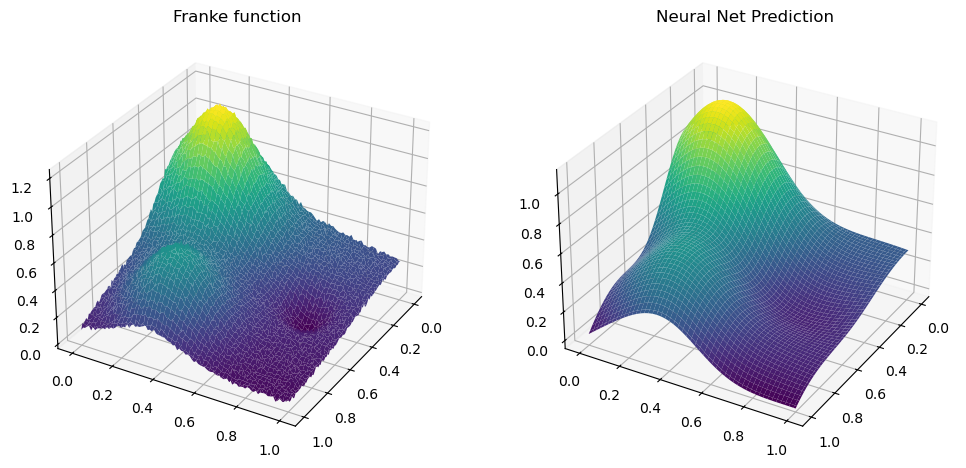

In [17]:
# Reshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
ax.view_init(azim=30)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Neural Net Prediction')
ax.view_init(azim=30)

plt.show()